In [1]:
#Import libraries

import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib
from pathlib import Path
%matplotlib inline
from PIL import Image
from shapely.geometry import Polygon

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 12, 8

/home/luisfigueiredo/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Get the eddies data: cyclonic and anticyclonic

Por razoes de memoria os 2 datasets tiveram de ser divididos apenas nas variaveis de interesse (latitude,longitude,time,track,effective_contour_longitude,effective_contour_latitude)

In [92]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [93]:
aviso_folder = os.path.join(current_path, '../data/AVISO')
aviso_folder

'/home/luisfigueiredo/JUNO/notebooks/../data/AVISO'

In [4]:
anticyclonic_path = os.path.join(aviso_folder, 'eddy_anticyclonic.nc')
anticyclonic_data = xr.load_dataset(anticyclonic_path)

In [117]:
anticyclonic_data

<xarray.Dataset>
Dimensions:                      (NbSample: 20, obs: 5837024)
Dimensions without coordinates: NbSample, obs
Data variables:
    effective_contour_latitude   (obs, NbSample) float32 61.73 61.66 ... -40.52
    effective_contour_longitude  (obs, NbSample) float32 301.1 301.4 ... 308.4
    latitude                     (obs) float32 61.94 61.9 ... -39.13 -39.03
    longitude                    (obs) float32 301.4 301.4 301.4 ... 308.6 308.6
    time                         (obs) datetime64[ns] 2018-01-01 ... 2022-10-23
    track                        (obs) uint32 0 0 0 0 ... 134000 134000 134000
Attributes: (12/21)
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    creator_email:             aviso@altimetry.fr
    creator_url:               https://www.aviso.altimetry.fr
    date_created:              2022-11-07T08:17:12Z
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    ...                        ...
    time_coverage_duration:    P1757D
    time_coverage_end:         2022-10-23T00:00:00Z
    time_coverage_start:       2018-01-01T00:00:00Z
    title:                     Mesoscale Anticyclonic Eddies in Altimeter Obs...
    history:                   Thu Nov 17 15:11:46 2022: ncks -v latitude,lon...
    NCO:                       netCDF Operators version 4.9.1 (Homepage = htt...

In [133]:
anticyclonic_data['time'].shape

(5837024,)

In [134]:
anticyclonic_data['longitude'].shape

(5837024,)

In [135]:
anticyclonic_data['track'].shape

(5837024,)

In [5]:
cyclonic_path = os.path.join(aviso_folder, 'eddy_cyclonic.nc')
cyclonic_data = xr.load_dataset(cyclonic_path)

In [89]:
cyclonic_data

<xarray.Dataset>
Dimensions:                      (NbSample: 20, obs: 6139093)
Dimensions without coordinates: NbSample, obs
Data variables:
    effective_contour_latitude   (obs, NbSample) float32 33.05 33.12 ... -37.12
    effective_contour_longitude  (obs, NbSample) float32 142.1 142.0 ... 320.1
    latitude                     (obs) float32 33.49 33.51 ... -35.62 -35.59
    longitude                    (obs) float32 142.4 142.3 142.5 ... 319.3 319.2
    time                         (obs) datetime64[ns] 2018-01-01 ... 2022-10-23
    track                        (obs) uint32 0 0 0 0 ... 139678 139678 139678
Attributes: (12/21)
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    creator_email:             aviso@altimetry.fr
    creator_url:               https://www.aviso.altimetry.fr
    date_created:              2022-11-07T08:19:47Z
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    ...                        ...
    time_coverage_duration:    P1757D
    time_coverage_end:         2022-10-23T00:00:00Z
    time_coverage_start:       2018-01-01T00:00:00Z
    title:                     Mesoscale Cyclonic Eddies in Altimeter Observa...
    history:                   Thu Nov 17 15:13:40 2022: ncks -v latitude,lon...
    NCO:                       netCDF Operators version 4.9.1 (Homepage = htt...

## Eddies identificados numa dada zona num dado periodo

### Identificação de Eddies Ciclonicos

In [6]:
#Tracking dos eddies cyclonicos
track_cyclonic = cyclonic_data['track'].values[(cyclonic_data['latitude'].values > 35) & (cyclonic_data['latitude'].values < 45) & (cyclonic_data['longitude'].values >341) & (cyclonic_data['longitude'].values < 355) & (cyclonic_data['time'].values == np.datetime64('2022-10-23T00:00:00.000000000'))]
track_cyclonic
# Eddies identified in the location: lat[35; 45] and lon[330;350] in 23 of October 2022

array([127363, 129778, 130217, 133063, 134978, 137071, 138690, 139415,
       139463, 139528], dtype=uint32)

In [7]:
eddies_track_cyc = np.unique(track_cyclonic)
eddies_track_cyc    # eddies cyclonicos unicos identificados na zona naquele periodo

array([127363, 129778, 130217, 133063, 134978, 137071, 138690, 139415,
       139463, 139528], dtype=uint32)

In [8]:
# guardar as coordenadas dos varios contours de longitude e latitude associados a cada eddie
eddie_cyc_lons = []
eddie_cyc_lats = []

#guardar as coordenadas (long e lat) dos centroids de cada eddie
centro_cyc_x = []
centro_cyc_y = []

for value in eddies_track_cyc:     #para cada um dos eddies (com um dado tracking number)
    # guardar as coordenadas dos varios contours de longitude e latitude associados a cada eddie
    
    x = cyclonic_data['effective_contour_longitude'].values[(cyclonic_data['track'] == value)][-1] - 360
    y = cyclonic_data['effective_contour_latitude'].values[(cyclonic_data['track'] == value)][-1]
    
    eddie_cyc_lons.append(list(x))
    eddie_cyc_lats.append(list(y))
    
    poly = Polygon(zip(x, y))
    
    poly_centroid_x = poly.centroid.coords[0][0]
    poly_centroid_y = poly.centroid.coords[0][1]
    
    centro_cyc_x.append(poly_centroid_x)
    centro_cyc_y.append(poly_centroid_y)

### Identificação de Eddies Anticiclonicos

In [9]:
#Tracking dos eddies anticyclonicos
track_ant = anticyclonic_data['track'].values[(anticyclonic_data['latitude'].values > 35) & (anticyclonic_data['latitude'].values < 45) & (anticyclonic_data['longitude'].values >341) & (anticyclonic_data['longitude'].values < 355) & (anticyclonic_data['time'].values == np.datetime64('2022-10-23T00:00:00.000000000'))]
track_ant

array([106085, 125626, 126808, 127395, 129534, 130403, 130902, 132016,
       132019, 132501, 132878, 133064, 133369, 133600, 133958],
      dtype=uint32)

In [10]:
eddies_track_anti = np.unique(track_ant)
eddies_track_anti    # eddies cyclonicos unicos identificados na zona naquele periodo

array([106085, 125626, 126808, 127395, 129534, 130403, 130902, 132016,
       132019, 132501, 132878, 133064, 133369, 133600, 133958],
      dtype=uint32)

In [11]:
# guardar as coordenadas dos varios contours de longitude e latitude associados a cada eddie
eddie_anti_lons = []
eddie_anti_lats = []

#guardar as coordenadas (long e lat) dos centroids de cada eddie
centro_anti_x = []
centro_anti_y = []

for value in eddies_track_anti:     #para cada um dos eddies (com um dado tracking number)
    # guardar as coordenadas dos varios contours de longitude e latitude associados a cada eddie
    
    x = anticyclonic_data['effective_contour_longitude'].values[(anticyclonic_data['track'] == value)][-1] - 360
    y = anticyclonic_data['effective_contour_latitude'].values[(anticyclonic_data['track'] == value)][-1]
    
    eddie_anti_lons.append(list(x))
    eddie_anti_lats.append(list(y))
    
    poly = Polygon(zip(x, y))
    
    poly_centroid_x = poly.centroid.coords[0][0]
    poly_centroid_y = poly.centroid.coords[0][1]
    
    centro_anti_x.append(poly_centroid_x)
    centro_anti_y.append(poly_centroid_y)

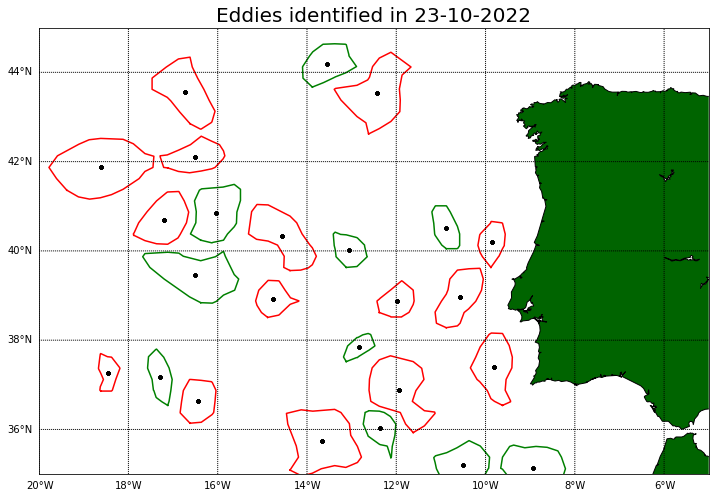

In [12]:
fig = plt.figure(figsize=(12,10))

m = Basemap(projection='cyl',
           llcrnrlat = 35,
           llcrnrlon = -20,
           urcrnrlat = 45,
           urcrnrlon = -5,
           resolution= 'i')

m.drawcoastlines()
m.fillcontinents(color = 'darkgreen')   #por zonas continentais a verde

#draw cyclonic eddies and its center
for i in range(len(eddie_cyc_lons)):
    x1_cyc, y1_cyc = m(eddie_cyc_lons[i], eddie_cyc_lats[i])
    eddies_centro_cyc_x, eddies_centro_cyc_y = m(centro_cyc_x, centro_cyc_y)
    m.plot(x1_cyc, y1_cyc, color='green')
    m.scatter(eddies_centro_cyc_x, eddies_centro_cyc_y, marker='.', color='black')
    
#draw anticyclonic eddies and its center
for i in range(len(eddie_anti_lons)):
    x1_anti, y1_anti = m(eddie_anti_lons[i], eddie_anti_lats[i])
    eddies_centro_anti_x, eddies_centro_anti_y = m(centro_anti_x, centro_anti_y)
    m.plot(x1_anti, y1_anti, color='red')
    m.scatter(eddies_centro_anti_x, eddies_centro_anti_y, marker='.', color='black')

m.drawparallels(np.arange(-90,90,2), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180,180,2), labels = [0,0,0,1])

plt.title('Eddies identified in 23-10-2022', fontsize=20)
plt.show()

## Eddies identificados numa dada zona num dado periodo

Mas agora vamos identificar o centro das varias posições que cada eddie ocupou num dado periodo.

### Identificação de Eddies Ciclonicos

In [13]:
#Tracking dos eddies cyclonicos
track_cyclonic = cyclonic_data['track'].values[(cyclonic_data['latitude'].values > 35) & (cyclonic_data['latitude'].values < 45) & (cyclonic_data['longitude'].values >341) & (cyclonic_data['longitude'].values < 355) & (cyclonic_data['time'].values > np.datetime64('2022-10-15T00:00:00.000000000'))]
track_cyclonic
# Eddies identified in the location: lat[35; 45] and lon[330;350] from 15 of October to 23 of October 2022

array([127363, 127363, 127363, 127363, 127363, 127363, 127363, 127363,
       128899, 128899, 129778, 129778, 129778, 129778, 129778, 129778,
       129778, 129778, 130217, 130217, 130217, 130217, 130217, 130217,
       130217, 130217, 130612, 130612, 130612, 130612, 130612, 131713,
       131713, 133063, 133063, 133063, 133063, 133063, 133063, 133063,
       133063, 133599, 133599, 133599, 133599, 133599, 133599, 133599,
       134406, 134978, 134978, 134978, 134978, 134978, 134978, 134978,
       134978, 135992, 135992, 135992, 135992, 136600, 136600, 136600,
       136600, 137071, 137071, 137071, 137071, 137071, 137071, 137071,
       137071, 138206, 138206, 138206, 138408, 138408, 138690, 138690,
       138690, 138690, 138690, 138690, 138690, 138690, 139230, 139230,
       139230, 139230, 139230, 139230, 139415, 139415, 139415, 139415,
       139415, 139415, 139415, 139415, 139463, 139463, 139463, 139463,
       139463, 139463, 139463, 139463, 139528, 139528, 139528, 139528,
      

In [14]:
eddies_track_cyc = np.unique(track_cyclonic)
eddies_track_cyc    # eddies cyclonicos unicos identificados na zona naquele periodo

array([127363, 128899, 129778, 130217, 130612, 131713, 133063, 133599,
       134406, 134978, 135992, 136600, 137071, 138206, 138408, 138690,
       139230, 139415, 139463, 139528], dtype=uint32)

In [15]:
track_cyc_list = []
track_cyc = list(track_cyclonic)
# Eddies identified in the location: lat[35; 45] and lon[330;350] from 20 of August to 30 of August 2022
eddies_track_cyc = np.unique(track_cyc)
for value in eddies_track_cyc:
    x = track_cyc.count(value)
    track_cyc_list.append([value, x])

In [85]:

eddie_cyc_lons = []
eddie_cyc_lats = []

centro_cyc_x = []
centro_cyc_y = []
for value in eddies_track_cyc:
    
    ####################################################################################
    #-360 nos valores maiores que 180
    ########################################################################
    
    x = cyclonic_data['effective_contour_longitude'].values[(cyclonic_data['track'] == value)][-1] - 360
    y = cyclonic_data['effective_contour_latitude'].values[(cyclonic_data['track'] == value)][-1] 
    
    eddie_cyc_lons.append(list(x))
    eddie_cyc_lats.append(list(y))
    
    
 #find center coordinates of all the eddies identified in those coordinates in that period
for value in track_cyc_list:
    
    for i in range(1, value[1] + 1):
    
        eddie_x = cyclonic_data['effective_contour_longitude'].values[(cyclonic_data['track'] == value[0])][-i] - 360
        eddie_y = cyclonic_data['effective_contour_latitude'].values[(cyclonic_data['track'] == value[0])][-i] 

        poly = Polygon(zip(eddie_x,eddie_y))

        poly_centroid_x = poly.centroid.coords[0][0]
        poly_centroid_y = poly.centroid.coords[0][1]
    
        if poly_centroid_x != -180.0:
            centro_cyc_x.append(poly_centroid_x)  #coordinates of the centroid
        if poly_centroid_y != 0.0:
            centro_cyc_y.append(poly_centroid_y)

### Identificação de Eddies Anti-Ciclonicos

In [17]:
#Tracking dos eddies anticyclonicos
track_anti = anticyclonic_data['track'].values[(anticyclonic_data['latitude'].values > 35) & (anticyclonic_data['latitude'].values < 45) & (anticyclonic_data['longitude'].values >341) & (anticyclonic_data['longitude'].values < 355) & (anticyclonic_data['time'].values > np.datetime64('2022-10-15T00:00:00.000000000'))]
track_anti
# Eddies identified in the location: lat[35; 45] and lon[330;350] from 15 of October to 23 of October 2022

array([106085, 106085, 106085, 106085, 106085, 106085, 106085, 106085,
       125626, 125626, 125626, 125626, 125626, 125626, 125626, 125626,
       126808, 126808, 126808, 126808, 126808, 126808, 126808, 126808,
       127395, 127395, 127395, 127395, 127395, 127395, 127395, 127395,
       128612, 128612, 128612, 128612, 129265, 129265, 129265, 129265,
       129265, 129265, 129534, 129534, 129534, 129534, 129534, 129534,
       129534, 129534, 130403, 130403, 130403, 130403, 130403, 130403,
       130403, 130403, 130902, 130902, 130902, 130902, 130902, 130902,
       130902, 130902, 132016, 132016, 132016, 132016, 132016, 132016,
       132016, 132016, 132019, 132019, 132019, 132019, 132019, 132019,
       132019, 132019, 132501, 132501, 132501, 132501, 132501, 132501,
       132501, 132501, 132878, 132878, 132878, 132878, 132878, 132878,
       132878, 132878, 132952, 132952, 132952, 132983, 132983, 132983,
       132983, 132983, 132983, 132983, 133064, 133064, 133064, 133064,
      

In [18]:
eddies_track_anti = np.unique(track_anti)
eddies_track_anti    # eddies anticyclonicos unicos identificados na zona naquele periodo

array([106085, 125626, 126808, 127395, 128612, 129265, 129534, 130403,
       130902, 132016, 132019, 132501, 132878, 132952, 132983, 133064,
       133369, 133532, 133600, 133675, 133958], dtype=uint32)

In [19]:
track_anti_list = []
track_anti = list(track_anti)
# Eddies identified in the location: lat[35; 45] and lon[330;350] from 20 of August to 30 of August 2022
eddies_track_anti = np.unique(track_anti)
for value in eddies_track_anti:
    x = track_anti.count(value)
    track_anti_list.append([value, x])

In [83]:

eddie_anti_lons = []
eddie_anti_lats = []

centro_anti_x = []
centro_anti_y = []
for value in eddies_track_anti:
    
    ####################################################################################
    #-360 nos valores maiores que 180
    ########################################################################
    
    x = anticyclonic_data['effective_contour_longitude'].values[(anticyclonic_data['track'] == value)][-1] - 360
    y = anticyclonic_data['effective_contour_latitude'].values[(anticyclonic_data['track'] == value)][-1] 

    eddie_anti_lons.append(list(x))
    eddie_anti_lats.append(list(y))
    
    
 #find center coordinates of all the eddies identified in those coordinates in that period
for value in track_anti_list:
    
    for i in range(1, value[1] + 1):
    
        eddie_x = anticyclonic_data['effective_contour_longitude'].values[(anticyclonic_data['track'] == value[0])][-i] - 360
        eddie_y = anticyclonic_data['effective_contour_latitude'].values[(anticyclonic_data['track'] == value[0])][-i] 

        poly = Polygon(zip(eddie_x,eddie_y))

        poly_centroid_x = poly.centroid.coords[0][0]
        poly_centroid_y = poly.centroid.coords[0][1]
        
        if poly_centroid_x != -180.0:
            centro_anti_x.append(poly_centroid_x)  #coordinates of the centroid
        if poly_centroid_y != 0.0:
            centro_anti_y.append(poly_centroid_y)

In [84]:
centro_anti_x

[-18.623048658795742,
 -18.624822174052046,
 -18.654937255687223,
 -18.668608610629786,
 -18.623172309896468,
 -18.65596073870438,
 -18.707046380691335,
 -18.7450112878442,
 -14.554553639629264,
 -14.501903049442845,
 -14.63275336537209,
 -14.4094796955073,
 -14.526765102883815,
 -14.432066563521003,
 -11.940975985365009,
 -12.047168172565614,
 -12.060860458870014,
 -12.041154166636472,
 -12.062132384437131,
 -12.08406373172955,
 -12.076919266252853,
 -12.091014799350349,
 -17.205547377273035,
 -17.191224451327045,
 -17.22532138435614,
 -17.17491657141623,
 -17.15322738662512,
 -17.114164013139757,
 -17.15406026327423,
 -17.157671687393833,
 -14.41638228424015,
 -14.36542679233309,
 -14.384023255394494,
 -14.320025095711651,
 -13.660339296708855,
 -13.647314826199551,
 -13.61725846303422,
 -13.590897826113572,
 -16.730809734657736,
 -16.690074029142362,
 -16.625356456120205,
 -16.622917116149072,
 -16.643231103368393,
 -16.633714848685997,
 -16.606995106161854,
 -16.61530890709705,
 -1

No handles with labels found to put in legend.


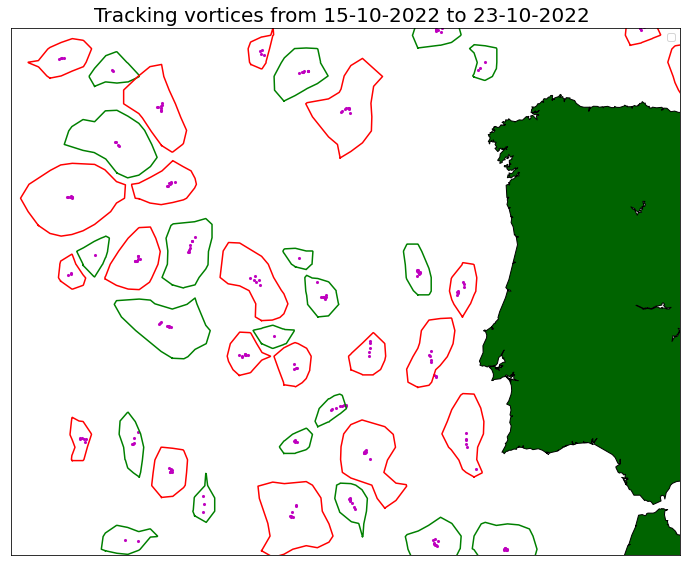

In [86]:
fig = plt.figure(figsize=(12,10))

m = Basemap(projection='mill',
           llcrnrlat = 35,                      #35
           llcrnrlon = -20,                     #-20
           urcrnrlat = 45,                      # 45
           urcrnrlon = -5,                      #-5
           resolution = 'i')

m.drawcoastlines()
m.fillcontinents(color = 'darkgreen')   #por zonas continentais a verde

#plot the shapes of the cyclonic eddies
for i in range(len(eddie_cyc_lons)):
    x1_cyc, y1_cyc = m(eddie_cyc_lons[i], eddie_cyc_lats[i])
    m.plot(x1_cyc, y1_cyc, color='green')

#all the centroid of the cyclonic eddies identified in a particular period
for j in range(len(centro_cyc_x)):
    eddies_centro_cyc_x, eddies_centro_cyc_y = m(centro_cyc_x[j], centro_cyc_y[j])
    m.scatter(eddies_centro_cyc_x, eddies_centro_cyc_y, marker='.', color='m', linewidths=0.1)
    
    
#plot the shapes of the anticyclonic eddies
for i in range(len(eddie_anti_lons)):
    x1_anti, y1_anti = m(eddie_anti_lons[i], eddie_anti_lats[i])
    m.plot(x1_anti, y1_anti, color='red')

#all the centroid of the cyclonic eddies identified in a particular period
for j in range(len(centro_anti_x)):
    eddies_centro_anti_x, eddies_centro_anti_y = m(centro_anti_x[j], centro_anti_y[j])
    m.scatter(eddies_centro_anti_x, eddies_centro_anti_y, marker='.', color='m', linewidths=0.1)

#m.drawparallels(np.arange(-90,90,2), labels = [True, False, False, False])
#m.drawmeridians(np.arange(-180,180, 2), labels=[0,0,0,1])

plt.title('Tracking vortices from 15-10-2022 to 23-10-2022 ', fontsize=20)
plt.legend()
plt.show()

## ----------------------- Save Results in a NetCDF -----------------------------------

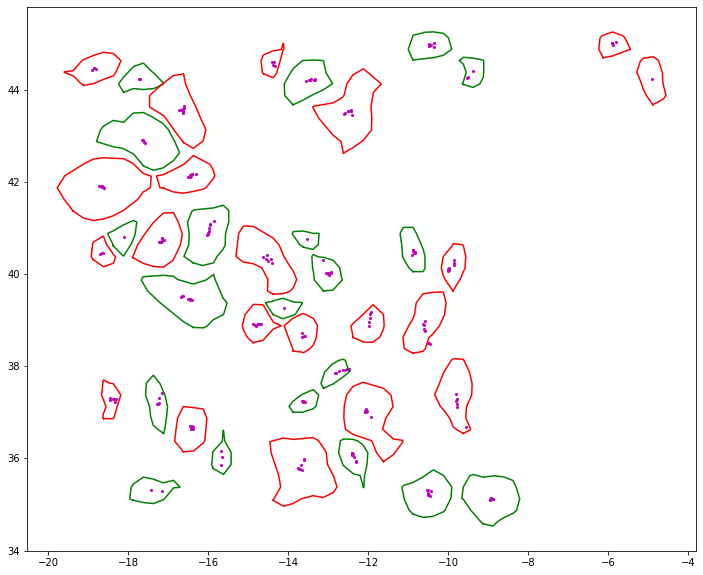

In [88]:
fig = plt.figure(figsize=(12,10))

#plot the shapes of the cyclonic  (CERTO)
for i in range(len(eddie_cyc_lons)):
    plt.plot(eddie_cyc_lons[i], eddie_cyc_lats[i], color='green');
   
 
for j in range(len(centro_cyc_x)):
    plt.scatter(centro_cyc_x[j], centro_cyc_y[j], marker='.', color='m', linewidths=0.1)
    
    
#plot the shapes of the anticyclonic eddies
for i in range(len(eddie_anti_lons)):
  #  x1_anti, y1_anti = m(eddie_anti_lons[i], eddie_anti_lats[i])
    plt.plot(eddie_anti_lons[i], eddie_anti_lats[i], color='red')

#all the centroid of the cyclonic eddies identified in a particular period
for j in range(len(centro_anti_x)):
  #  eddies_centro_anti_x, eddies_centro_anti_y = m(centro_anti_x[j], centro_anti_y[j])
    plt.scatter(centro_anti_x[j], centro_anti_y[j], marker='.', color='m', linewidths=0.1)



#plt.title('Tracking vortices from 15-10-2022 to 23-10-2022 ', fontsize=20)
#plt.legend()